In [1]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [2]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
import trace_mode

                                              ..-
    PyKat 1.0.9           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [3]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [4]:

#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(quantum_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SRMTT1_f_orig = kat.SRMTT1.f.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [5]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [6]:
###
###Extract the eigenmode of SRC with offsets in SRMHR
###

MMTL_f_offset = []
max_offset = 130 #20 microdiopters variance
steps = 5

### modulated q's at the face of SRMHR
SRMY_q1_x_list = []
SRMY_q1_y_list = []

### the q's @ nPRBS w/ resp to the SRMY Eigenmode
q_BS_SRCY_x = []
q_BS_SRCY_y = []

### the q's @ nPRBS w/ resp to the ITMY Eigenmode
q_BS_ITMY_x = []
q_BS_ITMY_y = []

### the q's @ nPRBS w/ resp to the OMC Eigenmode
q_BS_OMC_x = []
q_BS_OMC_y = []

### overlaps
overlap_SRC_to_ARM_x = []
overlap_SRC_to_ARM_y = []

overlap_OMC_to_ARM_x = []
overlap_OMC_to_ARM_y = []

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []


darm_list = []
out_list = []
freq = []

        
for i in range(1,steps+1,1):
    df = (float(i)/steps) * max_offset
    MMTL_f_offset.append(df)
    
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(darm_commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(quantum_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands(add_squeezing)
    basekat1.parseCommands("maxtem "+str(2))
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMTT f 
    kat1.SRMTT1.f.value = -df + 150

    #Run and extract the q's at the OFI and SRMHR
    out_new = kat1.run()
    SRCTL_q1_x = out_new["SRCoutx"]
    SRCTL_q1_y = out_new["SRCouty"]
    SRMY_q1_x = out_new["SRMYqx"]
    SRMY_q1_y = out_new["SRMYqy"]
    SRMY_q1_x_list.append(SRMY_q1_x)
    SRMY_q1_y_list.append(SRMY_q1_y)
    
    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')
    q_BS_SRCY_x.append(srcx)
    q_BS_SRCY_y.append(srcy)
    
    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')
    q_BS_ITMY_x.append(ARMx)
    q_BS_ITMY_y.append(ARMy)

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')
    q_BS_OMC_x.append(OMCx)
    q_BS_OMC_y.append(OMCy)

    overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))

    overlap_OMC_to_ARM_x.append(pykat.beam_param.overlap(OMCx,ARMx))
    overlap_OMC_to_ARM_y.append(pykat.beam_param.overlap(OMCy,ARMy))

    freq.append(out_new.x)
    out_list.append(out_new)
    darm_list.append(out_new['NSR_with_RP'])
    



Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [7]:
overlap_SRC_to_ARM_x

[0.9999999978510681,
 0.9999999978510681,
 0.9999999978510681,
 0.9999999978510681,
 0.9999999978510681]

In [8]:
overlap_OMC_to_ARM_x

[0.997534501482397,
 0.9960617279133609,
 0.99273405687621,
 0.982398504306178,
 0.913488262510513]

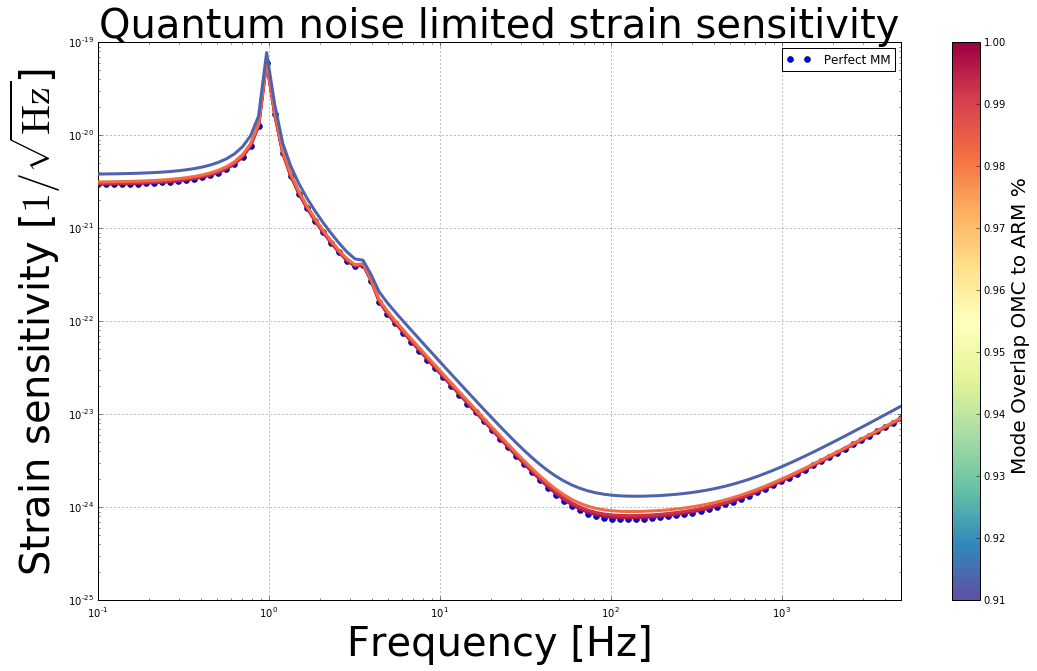

In [9]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(0.91, 1.0)

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(overlap_OMC_to_ARM_x[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)

    
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

pl.title("Quantum noise limited strain sensitivity",fontsize=40)
pl.xlim(freq[0].min(),freq[0].max())

pl.grid(True, zorder=-1)
pl.legend()

pl.xlabel("Frequency [Hz]",fontsize=40)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=40)


cb = pl.colorbar(s_m)
cb.set_label("Mode Overlap OMC to ARM % ", fontsize = 20)
cb.ax.tick_params(labelsize=10) 
cb.update_ticks()
pl.savefig("ht_varyingMMTL_w10dbSqz.png")

pl.show()

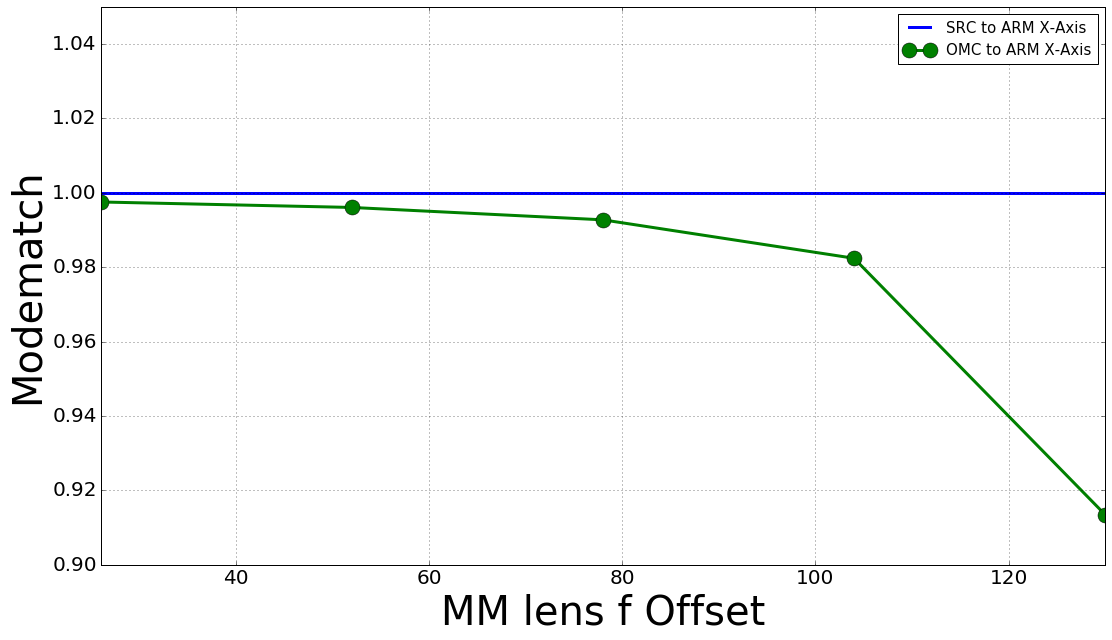

In [10]:
pl.figure(figsize=(18, 10), dpi=80)

pl.plot(MMTL_f_offset, overlap_SRC_to_ARM_x,linewidth=3, label='SRC to ARM X-Axis')
pl.plot(MMTL_f_offset, overlap_OMC_to_ARM_x,'o-',markersize=15,linewidth=3, label='OMC to ARM X-Axis')


pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=15)

pl.xlim(min(MMTL_f_offset),max(MMTL_f_offset))
pl.ylim(.9,1.05)

pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)

pl.savefig("MMvsMMToffset.png")

pl.xlabel("MM lens f Offset",fontsize=40)
pl.ylabel("Modematch",fontsize=40)

In [29]:
###This half of the code is for trying to figure out the mode-referencing for the squeezer

katfile_swpFC = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified_swpFC.kat"

basekat4 = pykat.finesse.kat() 
basekat4.loadKatFile(katfile_swpFC)
basekat4.parseCommands(darm_commands)
basekat4.parseCommands(amplitude_detectors)
basekat4.parseCommands(quantum_detectors)
basekat4.parseCommands(pds)
basekat4.parseCommands(add_squeezing)
basekat4.parseCommands("maxtem "+str(4))
basekat4.parseCommands(add_squeezing)
basekat4.parseCommands("""
bp sqz_qx x q nsqz
bp sqz_qy y q nsqz
""")

basekat4.undumpNodes()
kat4=basekat4.deepcopy()
kat4.verbose = False

kat4.SRMTT1.f.value = -MMTL_f_offset[-1] + 150

kat4.IMFC.T.value = 1.0
kat4.IMFC.R.value = 0.0
kat4.IMFC.L.value = 0.0


out4 = kat4.run()
freq_swpFC = out4.x
darm_swpFC= out4['NSR_with_RP']

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [12]:
kat_trace_data = kat.run(getTraceData=True) #Orginal, Perfect MM
kat_trace_data3 = kat1.run(getTraceData=True) #Not Bumpy, Bad MM
kat_trace_data4 = kat4.run(getTraceData=True) #Bumpy, Bad MM from FC Swp

In [24]:
####This has the SRM, and ARM matched well, but the Sqzing node is mismatched

katfile_sqz = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified_swpFC.kat"

basekat5 = pykat.finesse.kat() 
basekat5.loadKatFile(katfile_sqz)
basekat5.parseCommands(darm_commands)
basekat5.parseCommands(amplitude_detectors)
basekat5.parseCommands(quantum_detectors)
basekat5.parseCommands(pds)
basekat5.parseCommands(add_squeezing)
basekat5.parseCommands("maxtem "+str(2))
basekat5.parseCommands(add_squeezing)
basekat5.parseCommands("""
bp sqz_qx x q nsqz
bp sqz_qy y q nsqz
""")

sqz_qx = kat_trace_data4[1][0]['nsqz'][0]
sqz_qy = kat_trace_data4[1][0]['nsqz'][1]

sqz_gauss_cmd = 'gauss sqzgauss lsqz_FC nsqz '+ \
str(sqz_qx.w0) + ' ' + str(sqz_qx.z) + ' ' +\
str(sqz_qy.w0) + ' ' + str(sqz_qy.z)


basekat5.parseCommands(sqz_gauss_cmd)

basekat5.undumpNodes()
kat5=basekat5.deepcopy()
kat5.verbose = False

kat5.IMFC.T.value = 1.0
kat5.IMFC.R.value = 0.0
kat5.IMFC.L.value = 0.0

out5 = kat5.run()
freq_sqz_mismatch = out5.x
darm_sqz_mismatch= out5['NSR_with_RP']

Parsing `qd qdA 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `qd qdP 0 90 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd02 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd00m 0 0 0 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd01m 0 0 1 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd* sd02m 0 0 2 nOMC_AROC_trans` into pykat object not implemented yet, added as extra line.
Parsing `sd sd00OFI 0 0 0 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd sd01OFI 0 0 1 nIMFC1` into pykat object not implemented yet, added as extra line.
Parsing `sd

In [14]:
kat_trace_data5 = kat5.run(getTraceData=True) #Sqzer mismatched, everything else matched well.

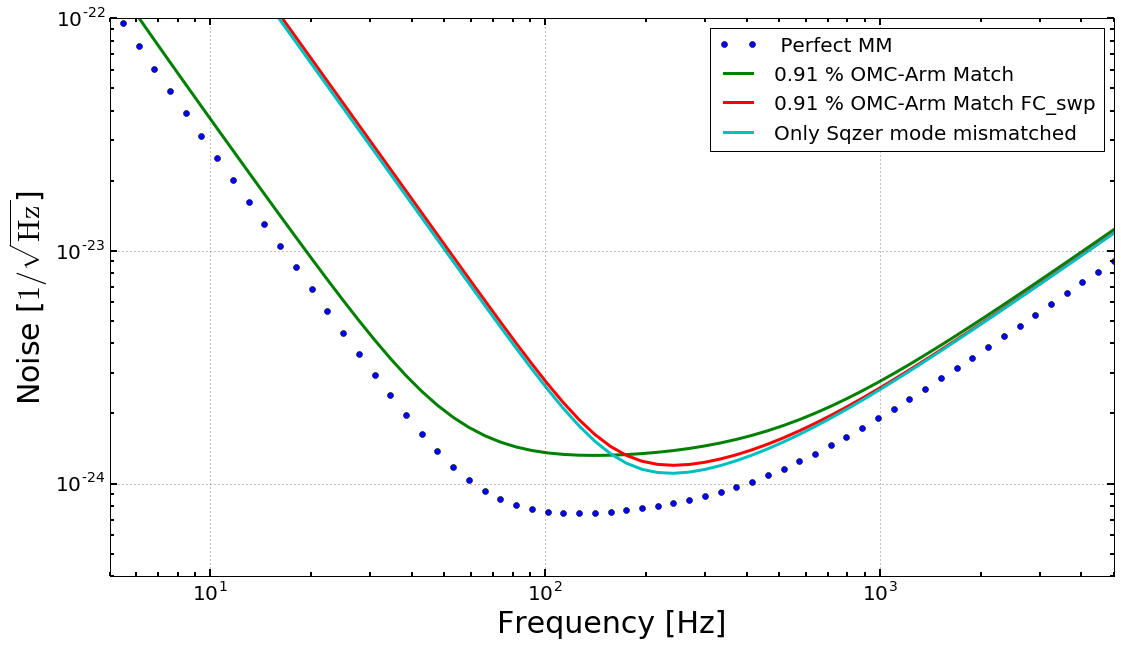

In [30]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)
pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')
pl.loglog(freq_swpFC, np.real(darm_list[-1]),linewidth=3, 
          label=str(round(overlap_OMC_to_ARM_x[-1],2))+' % OMC-Arm Match')
pl.loglog(freq_swpFC, np.real(darm_swpFC),linewidth=3, 
          label= str(round(overlap_OMC_to_ARM_x[-1],2))+' % OMC-Arm Match FC_swp')
pl.loglog(freq_sqz_mismatch, np.real(darm_sqz_mismatch),linewidth=3,
         label='Only Sqzer mode mismatched')

#pl.xlim(freq[0].min(),freq[0].max())
pl.xlim(5,5000)
pl.ylim(4e-25,1e-22)
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Noise [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

In [16]:
"""overlap30_list = []
overlap40_list = []
overlap34_list = []

overlap30_avg = []
overlap40_avg = []
overlap34_avg = []

for key in kat_trace_data[1][0]:
    q0 = kat_trace_data[1][0][key][0]._gauss_param__q
    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q
    overlap30 = pykat.beam_param.overlap(q0,q3)
    if round(overlap30,1) < 1.0:
        overlap30_list.append([key,overlap30])
        overlap30_avg.append(overlap30)
        
for key in kat_trace_data[1][0]:
    q0 = kat_trace_data[1][0][key][0]._gauss_param__q
    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q
    overlap40 = pykat.beam_param.overlap(q0,q4)
    if round(overlap40,1) < 1.0:
        overlap40_list.append([key,overlap40])
        overlap40_avg.append(overlap40)
        
for key in kat_trace_data[1][0]:
    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q
    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q
    overlap34 = pykat.beam_param.overlap(q3,q4)
    if round(overlap34,1) < 1.0:
        overlap34_list.append([key,overlap34])
        overlap34_avg.append(overlap34)

avg_30 = sum(overlap30_avg)/len(overlap30_avg)
avg_40 = sum(overlap40_avg)/len(overlap40_avg)
avg_34 = sum(overlap34_avg)/len(overlap34_avg)

print(avg_30,avg_40,avg_34)"""

'overlap30_list = []\noverlap40_list = []\noverlap34_list = []\n\noverlap30_avg = []\noverlap40_avg = []\noverlap34_avg = []\n\nfor key in kat_trace_data[1][0]:\n    q0 = kat_trace_data[1][0][key][0]._gauss_param__q\n    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q\n    overlap30 = pykat.beam_param.overlap(q0,q3)\n    if round(overlap30,1) < 1.0:\n        overlap30_list.append([key,overlap30])\n        overlap30_avg.append(overlap30)\n        \nfor key in kat_trace_data[1][0]:\n    q0 = kat_trace_data[1][0][key][0]._gauss_param__q\n    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q\n    overlap40 = pykat.beam_param.overlap(q0,q4)\n    if round(overlap40,1) < 1.0:\n        overlap40_list.append([key,overlap40])\n        overlap40_avg.append(overlap40)\n        \nfor key in kat_trace_data[1][0]:\n    q3 = kat_trace_data3[1][0][key][0]._gauss_param__q\n    q4 = kat_trace_data4[1][0][key][0]. _gauss_param__q\n    overlap34 = pykat.beam_param.overlap(q3,q4)\n    if round(overlap3

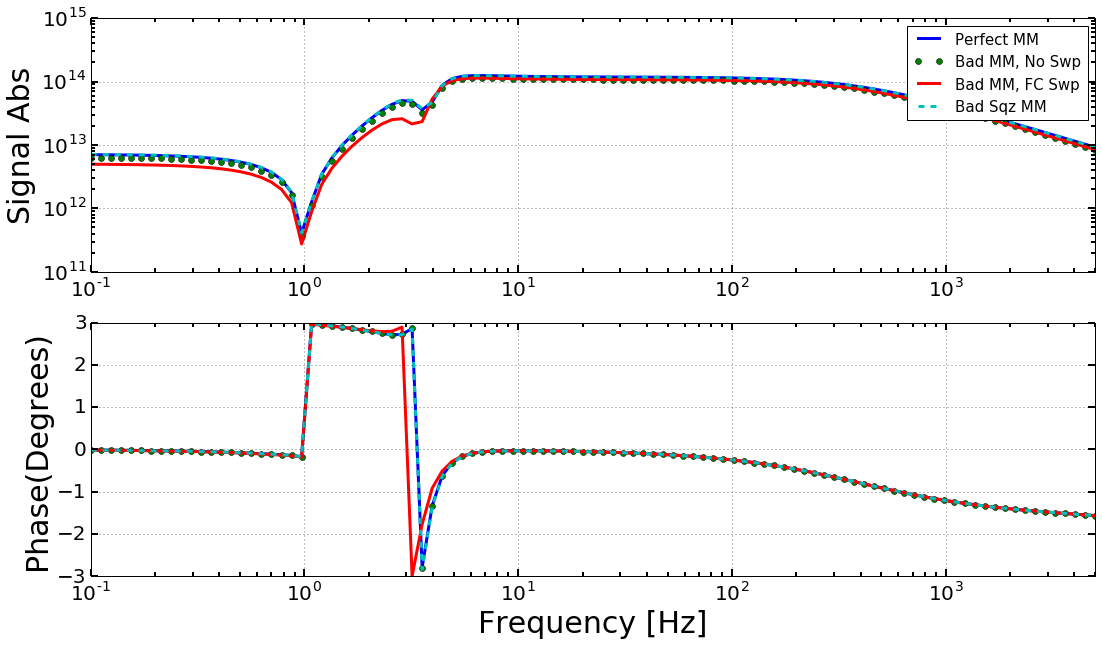

In [17]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(211)

pl.loglog(freq[0], np.absolute(out_perfect_mm['signal']),linewidth=3, label='Perfect MM')
pl.loglog(freq[0], np.absolute(out_list[-1]['signal']),'o',linewidth=3, label='Bad MM, No Swp')
pl.loglog(freq[0], np.absolute(out4['signal']),linewidth=3, label='Bad MM, FC Swp')
pl.loglog(freq[0], np.absolute(out5['signal']),'--',linewidth=3, label='Bad Sqz MM')


###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.ylabel("Signal Abs",fontsize=30)
pl.legend(fontsize=15)


pl.subplot(212)
pl.semilogx(freq[0], np.angle(out_perfect_mm['signal']),linewidth=3, label='Perfect MM')
pl.semilogx(freq[0], np.angle(out_list[-1]['signal']),'o',linewidth=3, label='Bad MM, No Swp')
pl.semilogx(freq[0], np.angle(out4['signal']),linewidth=3, label='Bad MM, FC Swp')
pl.semilogx(freq[0], np.angle(out5['signal']),'--',linewidth=3, label='Bad Sqz MM')

pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Phase(Degrees)",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

pl.show()

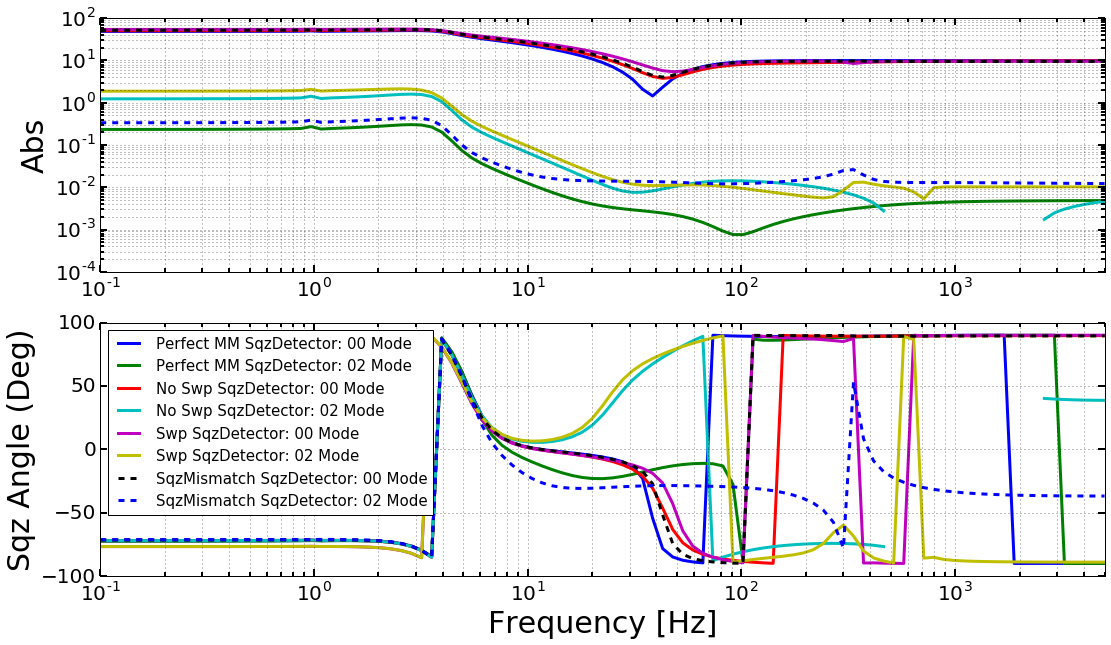

In [18]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(211)

pl.loglog(freq[0], np.absolute(out_perfect_mm['sd00']),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out_perfect_mm['sd02']),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out_list[-1]['sd00']),linewidth=3, label='No Swp SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out_list[-1]['sd02']),linewidth=3, label='No Swp SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out4['sd00']),linewidth=3, label='Swp SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out4['sd02']),linewidth=3, label='Swp SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out5['sd00']),'--',linewidth=3, label='SqzMismatch SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out5['sd02']),'--',linewidth=3, label='SqzMismatch SqzDetector: 02 Mode')

###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.ylabel("Abs",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1, which = 'both')

pl.subplot(212)
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd00'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd02'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out_list[-1]['sd00'],deg=True),linewidth=3, label='No Swp SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out_list[-1]['sd02'],deg=True),linewidth=3, label='No Swp SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out4['sd00'],deg=True),linewidth=3, label='Swp SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out4['sd02'],deg=True),linewidth=3, label='Swp SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out5['sd00'],deg=True),'--',linewidth=3, label='SqzMismatch SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out5['sd02'],deg=True),'--',linewidth=3, label='SqzMismatch SqzDetector: 02 Mode')

###Main plot formatting
pl.grid(True, zorder=-1, which = 'both')
pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Sqz Angle (Deg)",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.legend(fontsize=15, loc=2)

pl.show()

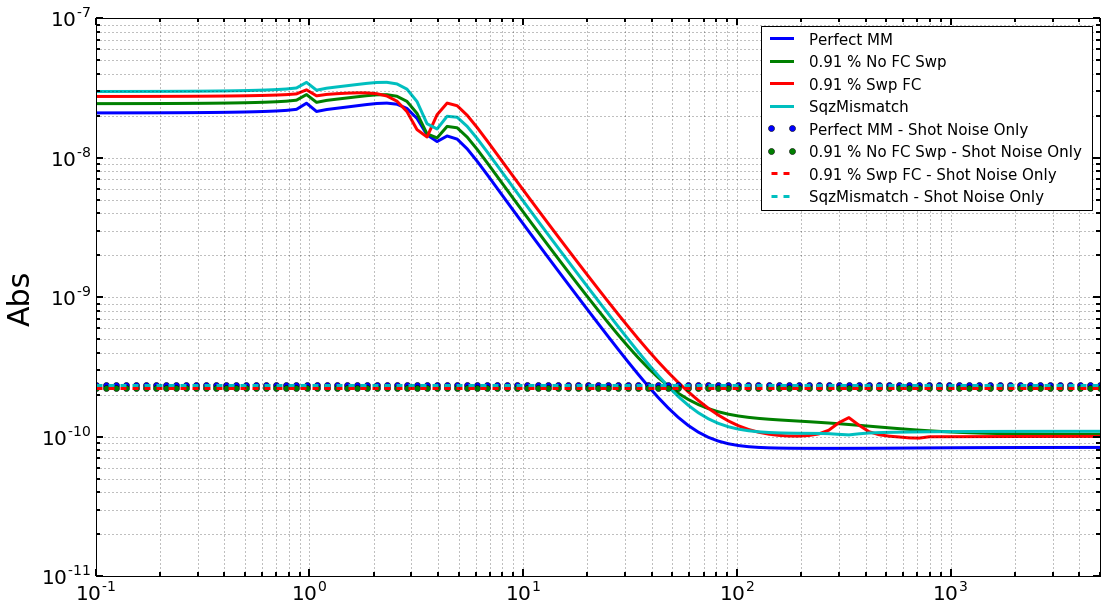

In [19]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)

pl.loglog(freq[0], np.absolute(out_perfect_mm['PDquantumnoise']),linewidth=3,
          label='Perfect MM')
pl.loglog(freq[0], np.absolute(out_list[-1]['PDquantumnoise']),linewidth=3,
          label=str(round(overlap_OMC_to_ARM_x[-1],2))+' % No FC Swp ')
pl.loglog(freq[0], np.absolute(out4['PDquantumnoise']),linewidth=3,
          label=str(round(overlap_OMC_to_ARM_x[-1],2))+' % Swp FC')
pl.loglog(freq[0], np.absolute(out5['PDquantumnoise']),linewidth=3,
          label='SqzMismatch')

pl.loglog(freq[0], np.absolute(out_perfect_mm['PDshotnoise']),'o',linewidth=3,
          label='Perfect MM - Shot Noise Only', color ='b')
pl.loglog(freq[0], np.absolute(out_list[-1]['PDshotnoise']),'o',linewidth=3,
          label=str(round(overlap_OMC_to_ARM_x[-1],2))+' % No FC Swp - Shot Noise Only ', color ='g')
pl.loglog(freq[0], np.absolute(out4['PDshotnoise']),'--',linewidth=3,
          label=str(round(overlap_OMC_to_ARM_x[-1],2))+' % Swp FC - Shot Noise Only', color ='r')
pl.loglog(freq[0], np.absolute(out5['PDshotnoise']),'--',linewidth=3,
          label='SqzMismatch - Shot Noise Only', color ='c')



pl.xlim(freq[0].min(),freq[0].max())

pl.ylabel("Abs",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1, which = 'both')
pl.legend(fontsize=15, loc=1)

In [20]:
# Take the node and trace to each caviy for the two ifos, swp and no swp for the FC
# 

node = 'nsqz'

qx_test_node3 = kat_trace_data3[1][0][node][0]._gauss_param__q
qy_test_node3 = kat_trace_data3[1][0][node][0]._gauss_param__q

for cav in kat1.getAll(pykat.commands.cavity):
    [qx,qy]= trace_mode.from_cav_to_node(kat1,cav.name,node)
    overlap_x = pykat.beam_param.overlap(qx,qx_test_node3)
    overlap_y = pykat.beam_param.overlap(qy,qy_test_node3)
    print(cav.name, round(overlap_x,2), round(overlap_y,2))

cavFC 1.0 1.0
cavYARM 0.91 0.92
cavPRY 0.92 0.92
cavXARM 0.91 0.92
cavSRY 0.91 0.9
cavSRX 0.91 0.9
cavOMC 1.0 1.0
cavIMC 0.91 0.92
cavPRX 0.92 0.92


In [21]:
#Bumps

qx_test_node4 = kat_trace_data4[1][0][node][0]._gauss_param__q
qy_test_node4 = kat_trace_data4[1][0][node][0]._gauss_param__q

for cav in kat4.getAll(pykat.commands.cavity):
    [qx,qy]= trace_mode.from_cav_to_node(kat4,cav.name,node) #Get the q at the node in ref to each cav basis
    overlap_x = pykat.beam_param.overlap(qx,qx_test_node4)
    overlap_y = pykat.beam_param.overlap(qy,qy_test_node4)
    print(cav.name, round(overlap_x,2), round(overlap_y,2))

cavFC 0.91 0.91
cavXARM 1.0 1.0
cavYARM 1.0 1.0
cavPRY 1.0 1.0
cavSRY 1.0 1.0
cavSRX 1.0 1.0
cavOMC 0.91 0.91
cavIMC 1.0 1.0
cavPRX 1.0 1.0


In [22]:
qx_test_node5 = kat_trace_data5[1][0][node][0]._gauss_param__q
qy_test_node5 = kat_trace_data5[1][0][node][1]._gauss_param__q

for cav in kat.getAll(pykat.commands.cavity):
    [qx,qy]= trace_mode.from_cav_to_node(kat,cav.name,node)
    overlap_x = pykat.beam_param.overlap(qx,qx_test_node5)
    overlap_y = pykat.beam_param.overlap(qy,qy_test_node5)
    print(cav.name,qx, round(overlap_x,2), round(overlap_y,2))

cavFC (8.00000000541322+7.99949998437436j) 0.91 0.9
cavYARM (8.0448199504002+8.00909817992866j) 0.91 0.88
cavPRY (7.97222013199822+7.88139240298283j) 0.91 0.88
cavXARM (8.0446099915073+8.00935602590294j) 0.91 0.88
cavSRY (8.0445432085806+8.00861649683913j) 0.91 0.89
cavSRX (8.0440782953313+8.00843040271148j) 0.91 0.89
cavOMC (8.04105597511452+8.00635426537706j) 0.91 0.9
cavIMC (8.23861219047375+7.99410776240479j) 0.91 0.88
cavPRX (7.97184318273103+7.88133321836008j) 0.91 0.88


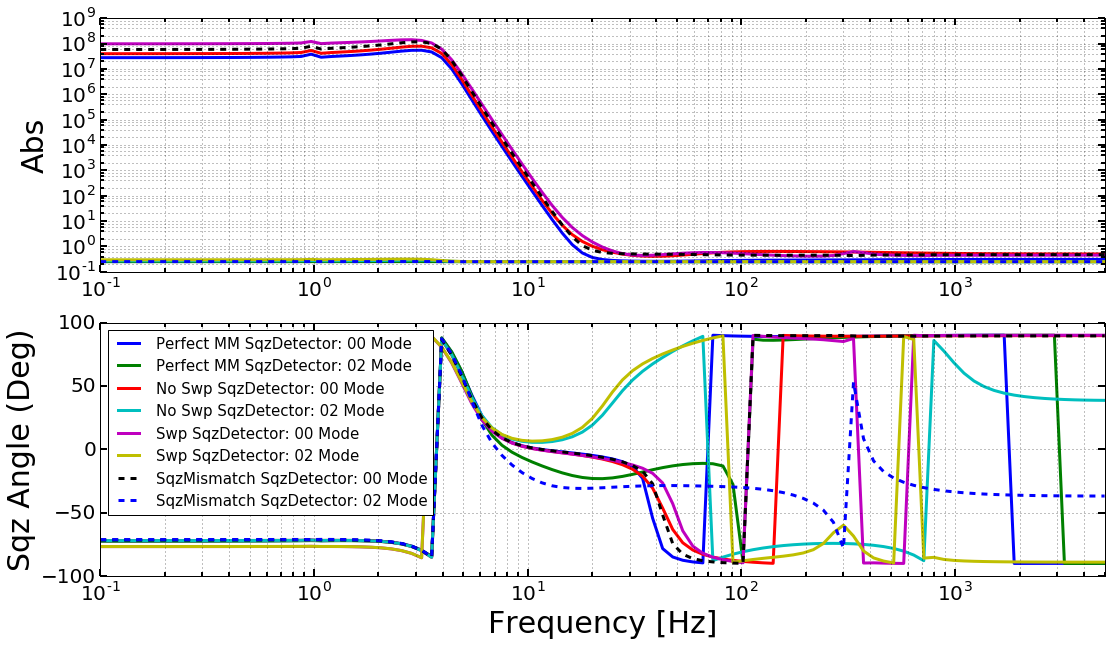

In [23]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(211)

pl.loglog(freq[0], np.absolute(out_perfect_mm['sd00m']),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out_perfect_mm['sd02m']),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out_list[-1]['sd00m']),linewidth=3, label='No Swp SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out_list[-1]['sd02m']),linewidth=3, label='No Swp SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out4['sd00m']),linewidth=3, label='Swp SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out4['sd02m']),linewidth=3, label='Swp SqzDetector: 02 Mode')

pl.loglog(freq[0], np.absolute(out5['sd00m']),'--',linewidth=3, label='SqzMismatch SqzDetector: 00 Mode')
pl.loglog(freq[0], np.absolute(out5['sd02m']),'--',linewidth=3, label='SqzMismatch SqzDetector: 02 Mode')

###Main plot formatting
pl.xlim(freq[0].min(),freq[0].max())
pl.ylabel("Abs",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1, which = 'both')

pl.subplot(212)
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd00m'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out_perfect_mm['sd02m'],deg=True),linewidth=3, label='Perfect MM SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out_list[-1]['sd00m'],deg=True),linewidth=3, label='No Swp SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out_list[-1]['sd02m'],deg=True),linewidth=3, label='No Swp SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out4['sd00m'],deg=True),linewidth=3, label='Swp SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out4['sd02m'],deg=True),linewidth=3, label='Swp SqzDetector: 02 Mode')

pl.semilogx(freq[0], np.angle(out5['sd00m'],deg=True),'--',linewidth=3, label='SqzMismatch SqzDetector: 00 Mode')
pl.semilogx(freq[0], np.angle(out5['sd02m'],deg=True),'--',linewidth=3, label='SqzMismatch SqzDetector: 02 Mode')

###Main plot formatting
pl.grid(True, zorder=-1, which = 'both')
pl.xlim(freq[0].min(),freq[0].max())
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Sqz Angle (Deg)",fontsize=30)
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.legend(fontsize=15, loc=2)
